In [11]:
import torch

from torch.optim import SGD
import os
from PIL import Image
import numpy as np
from tqdm import tqdm, trange
from torch.autograd import Variable
import subprocess
import math

import wandb
import random
import matplotlib.pyplot as plt

import time

from configs.generic_configs import get_preprocessing_and_other_configs
from configs.dlgn_conv_config import HardRelu
from utils.data_preprocessing import preprocess_dataset_get_data_loader, segregate_classes
from structure.generic_structure import PerClassDataset
from model.model_loader import get_model_from_loader
from conv4_models import get_model_instance, get_img_size
import scipy.ndimage as nd
from collections import OrderedDict
from external_utils import format_time
from utils.visualise_utils import save_image, recreate_image, add_lower_dimension_vectors_within_itself, format_np_output
from visualization import TemplateImageGenerator,get_initial_image,preprocess_image,blur_img
from torch.utils.data import TensorDataset, DataLoader
from freq_dataset_generator import frequency_band_pass

In [2]:
def imshow(img,ratio=2):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    aspect_ratio = img.shape[0] / img.shape[1]
    new_width = int(img.shape[1]*ratio)
    new_height = int(new_width * aspect_ratio)
    print("img size",img.shape)
    if isinstance(img, (np.ndarray, np.generic,torch.Tensor)):
        if isinstance(img, torch.Tensor):
          img = format_np_output(img.numpy())
        else:
          img = format_np_output(img)
        print("img size after formatting",img.shape)
        img = Image.fromarray(img)
    print("(new_width,new_height)",(new_width,new_height))
    img = img.resize((new_width,new_height),resample=Image.BICUBIC)
    img.show()

In [117]:
dataset = "cifar10"
valid_split_size = 0.9
torch_seed = 2022
vis_version = "V2"
is_split_validation = False
model_arch_type = 'dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__'
# model_arch_type = 'dlgn__st1_pad2_vgg16_bn_wo_bias__'

# custom_model_path = "root/model/save/cifar10/CLEAN_TRAINING/ST_2022/dlgn__st1_pad2_vgg16_bn_wo_bias___PRET_False_dir.pt"
custom_model_path = "root/model/save/cifar10/CLEAN_TRAINING/ST_2022/dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias___PRET_False_dir.pt"

In [118]:
classes, num_classes, ret_config = get_preprocessing_and_other_configs(
    dataset, valid_split_size, batch_size=32)
    
trainloader, _, testloader = preprocess_dataset_get_data_loader(
    ret_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=is_split_validation)

Files already downloaded and verified


In [119]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)
inp_channel = get_img_size(dataset)[0]
temp_model = torch.load(custom_model_path, map_location=device)
model = get_model_instance(
    model_arch_type, inp_channel, seed=torch_seed, num_classes=num_classes)
if(isinstance(temp_model, dict)):
    if("module." in [*temp_model['state_dict'].keys()][0]):
        new_state_dict = OrderedDict()
        for k, v in temp_model['state_dict'].items():
            name = k[7:]  # remove 'module.' of dataparallel
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(temp_model['state_dict'])
else:
    model.load_state_dict(temp_model.state_dict())
model = model.to(device)
input_data_list_per_class = segregate_classes(
        model, trainloader, testloader, num_classes, True, True)

device cuda


Processing original loader: 100%|██████████| 1563/1563 [00:08<00:00, 182.16it/s]

trainset Ground truth segregation of classes:
Indx 0 len:5000
Indx 1 len:5000
Indx 2 len:5000
Indx 3 len:5000
Indx 4 len:5000
Indx 5 len:5000
Indx 6 len:5000
Indx 7 len:5000
Indx 8 len:5000
Indx 9 len:5000
Sum 50000


In [120]:
def show_img(x2):
    im2 = recreate_image(x2, False)
    if isinstance(im2, (np.ndarray, np.generic)):
        im2 = format_np_output(im2)
        im2 = Image.fromarray(im2)
    im2 = im2.resize((200, 200))
    im2.show()

In [121]:
class_indx = 1
per_class_dataset = PerClassDataset(
    input_data_list_per_class[class_indx], class_indx)
per_class_loader = torch.utils.data.DataLoader(per_class_dataset, batch_size=2,
                                               shuffle=False)

2 Images batch

In plane class indices (17,13)
In car = (13,14)
In cat = (56.42)
In deer = (10,12)
In dog = (105,111)

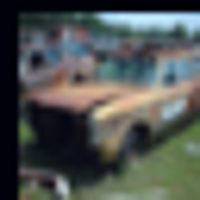

In [144]:
ind1 = 14
x1,y1 = per_class_dataset[ind1][0],per_class_dataset[ind1][1]
show_img(x1)

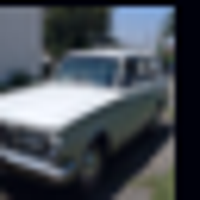

In [145]:
ind2 = 13
ox2,y2 = per_class_dataset[ind2][0],per_class_dataset[ind2][1]
show_img(ox2)

In [146]:
fbase = frequency_band_pass(ox2.size(),["LB","MB"]).to("cuda")

In [147]:
tmp_gen = TemplateImageGenerator(
    model, get_initial_image(dataset, "zero_init_image"))

In [148]:
tmp_batch = torch.stack([x1,ox2]).to("cuda")

In [149]:
torch.nn.Softmax(dim=1)(model(tmp_batch))

tensor([[7.2199e-02, 8.3035e-01, 1.4917e-03, 1.0039e-04, 1.3774e-02, 7.7032e-05,
         8.0378e-04, 9.5371e-04, 4.2389e-02, 3.7859e-02],
        [1.0932e-01, 7.5025e-01, 2.1677e-03, 1.3190e-05, 2.3079e-04, 3.5671e-06,
         5.8566e-05, 9.6491e-05, 8.0821e-02, 5.7035e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [150]:

tmp_batch = torch.fft.fft2(tmp_batch)
tmp_batch = torch.fft.fftshift(tmp_batch)
tmp_batch = fbase * tmp_batch
tmp_batch = torch.fft.ifftshift(tmp_batch)
tmp_batch = torch.real(torch.fft.ifft2(tmp_batch))

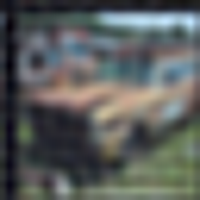

In [151]:
show_img(tmp_batch[0])

In [152]:
torch.nn.Softmax(dim=1)(model(tmp_batch))

tensor([[0.0759, 0.1029, 0.0637, 0.0090, 0.5064, 0.1105, 0.0012, 0.0812, 0.0402,
         0.0091],
        [0.0528, 0.3401, 0.0717, 0.0027, 0.0343, 0.0039, 0.0029, 0.0100, 0.4500,
         0.0316]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [153]:
# sft_chk = torch.roll(torch.stack([ox2,x1]),shifts=(10, 5), dims=(-1, -2))
# sft_chk[:,:,0:6,:] = ox2.min()
# sft_chk[:,:,:,0:11] = ox2.min()
# # sft_chk = ox2.flip(-1)
# show_img(sft_chk[1])

In [154]:
new_dataset = TensorDataset(tmp_batch,torch.tensor([y1,y2]).to(tmp_gen.device))
# new_dataset = TensorDataset(torch.stack([x1,ox2]).to(tmp_gen.device),torch.tensor([y1,y2]).to(tmp_gen.device))
loader = torch.utils.data.DataLoader(new_dataset, batch_size=1,shuffle=False)

In [155]:
number_of_batch_to_collect = 2
tmp_gen.reset_collection_state()
per_class_data_loader = tqdm(
    loader, desc='Collecting active maps class label:'+str(classes[class_indx]))
for i, per_class_per_batch_data in enumerate(per_class_data_loader):
    torch.cuda.empty_cache()
    c_inputs, _ = per_class_per_batch_data

    opt_img = tmp_gen.collect_active_pixel_per_batch(
        per_class_per_batch_data,is_set_rolled_part_zero=False)
    
    if(not(number_of_batch_to_collect is None) and i == number_of_batch_to_collect - 1):
            break


tmp_gen.update_overall_y_maps(collect_threshold=0.9)

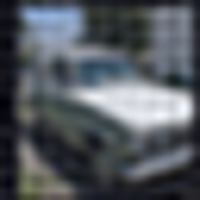

In [156]:
show_img(opt_img)

In [157]:
alpha = 0
normalize_image = False
class_image, _ = next(iter(loader))
class_image = class_image.to(tmp_gen.device, non_blocking=True)
if(vis_version == 'V2' or vis_version == 'V3'):
    if('conv4_deep_gated_net' in model_arch_type):
        number_of_image_optimization_steps = 301
    else:
        number_of_image_optimization_steps = 161
    if(vis_version == 'V2'):
        start_sigma = 0.75
        end_sigma = 0.1
    elif(vis_version == 'V3'):
        start_sigma = 0.1
        end_sigma = 0.75
    if('conv4_deep_gated_net' in model_arch_type):
        start_step_size = 1
        end_step_size = 0.5
    else:
        start_step_size = 0.1
        end_step_size = 0.05

for repeat in range(1):

    if(repeat == 1):
        alpha = 0.1

    print(
        "^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ alpha", alpha)

    num_classes = len(classes)

    tmp_gen.initial_image = preprocess_image(
        tmp_gen.original_image.cpu().clone().detach().numpy(), normalize_image)

    tmp_gen.initial_image = tmp_gen.initial_image.to(tmp_gen.device)

    tmp_gen.initial_image.requires_grad_()

    step_size = 0.01
    if(vis_version == 'V2' or vis_version == 'V3'):
        with trange(number_of_image_optimization_steps, unit="iter", desc="Generating template image V2") as pbar:
            for step_iter in pbar:
                begin_time = time.time()
                pbar.set_description(f"Iteration {step_iter+1}")

                step_size = start_step_size + \
                    ((end_step_size - start_step_size) * step_iter) / \
                    number_of_image_optimization_steps
                # optimizer = torch.optim.SGD([img_var], lr=step_size)
                sigma = start_sigma + \
                    ((end_sigma - start_sigma) * step_iter) / \
                    number_of_image_optimization_steps

                outputs = tmp_gen.model(tmp_gen.initial_image)

                verbose = 1
                loss, active_pixel_points, total_pixel_points, non_zero_pixel_points = tmp_gen.get_loss_value(
                    "TEMP_LOSS", 0, outputs, class_image, alpha, verbose)

                # print("{} Loss: {}".format(template_loss_type, loss))
                if(step_iter == 0 and active_pixel_points is not None):
                    percent_active_pixels = float((
                        active_pixel_points/total_pixel_points)*100)
                    print("active_pixel_points", active_pixel_points)
                    print("total_pixel_points", total_pixel_points)
                    print("Percentage of active pixels:",
                            percent_active_pixels)

                # Backward
                loss.backward()

                unnorm_gradients = tmp_gen.initial_image.grad
                # std_unnorm_grad = torch.std(unnorm_gradients)
                norm_grad = torch.norm(unnorm_gradients)
                # print("torch.norm(unnorm_gradients):",
                #       norm_grad)
                # print("std_unnorm_grad:", std_unnorm_grad)
                # print("Original self.initial_image gradients", gradients)

                # gradients = unnorm_gradients / first_norm
                gradients = unnorm_gradients / \
                    norm_grad + 1e-8

                # print("torch.norm(gradients):",
                #       torch.norm(gradients))

                with torch.no_grad():
                    # self.initial_image = self.initial_image - gradients*step_size
                    blurred_grad = gradients.cpu().detach().numpy()[0]
                    blurred_grad = blur_img(
                        blurred_grad, sigma)
                    tmp_gen.initial_image = tmp_gen.initial_image.cpu().detach().numpy()[
                        0]
                    tmp_gen.initial_image -= step_size / \
                        np.abs(blurred_grad).mean() * blurred_grad

                    # optimizer.step()
                    # print("sigma:", sigma)

                    tmp_gen.initial_image = blur_img(
                        tmp_gen.initial_image, sigma)
                    tmp_gen.initial_image = torch.from_numpy(
                        tmp_gen.initial_image[None])

                tmp_gen.initial_image = tmp_gen.initial_image.to(tmp_gen.device)
                tmp_gen.initial_image.requires_grad_()
                cur_time = time.time()
                tot_time = cur_time - begin_time

                pbar.set_postfix(loss=loss.item(), norm_image=torch.norm(
                    tmp_gen.initial_image).item(), norm_grad=torch.norm(gradients).item(), norm_raw_grad=norm_grad.item(), it_time=format_time(tot_time))

reconst_outputs = tmp_gen.model(tmp_gen.initial_image)
reconst_outputs_softmax = reconst_outputs.softmax(dim=1)
reconst_img_norm = torch.norm(tmp_gen.initial_image)
print("Norm of reconstructed image is:", reconst_img_norm)
print("Confidence over Reconstructed image with alpha:", alpha)
for i in range(len(reconst_outputs_softmax[0])):
    print("Class {} => {}".format(
        classes[i], reconst_outputs_softmax[0][i]))
reconst_pred = reconst_outputs_softmax.max(1).indices
print("Reconstructed image Class predicted:",
        classes[reconst_pred])

image = preprocess_image(
    class_image[0].cpu().clone().detach().numpy(), normalize_image)
image = image.to(tmp_gen.device)

image.requires_grad_()
original_image_outputs = tmp_gen.model(image)
original_image_outputs_softmax = original_image_outputs.softmax(
    dim=1)
print("Confidence over original image with alpha:", alpha)
for i in range(len(original_image_outputs_softmax[0])):
    print("Class {} => {}".format(
        classes[i], original_image_outputs_softmax[0][i]))
original_image_pred = original_image_outputs_softmax.max(1).indices
print("Class predicted on original image was :",
        classes[original_image_pred])
print("Original label was:", classes[class_indx])

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ alpha 0


Iteration 2:   1%|          | 1/161 [00:00<00:20,  7.82iter/s, it_time=118ms, loss=1.42, norm_grad=1, norm_image=7.91, norm_raw_grad=0.0116]

active_pixel_points 237716
total_pixel_points 703488
Percentage of active pixels: 33.79105258369724


Iteration 161: 100%|██████████| 161/161 [00:24<00:00,  6.56iter/s, it_time=141ms, loss=0.924, norm_grad=1, norm_image=368, norm_raw_grad=0.00119]

Norm of reconstructed image is: tensor(368.2372, device='cuda:0', grad_fn=<CopyBackwards>)
Confidence over Reconstructed image with alpha: 0
Class plane => 0.08392991125583649
Class car => 0.047367244958877563
Class bird => 0.2993130385875702
Class cat => 0.08000524342060089
Class deer => 0.11480864137411118
Class dog => 0.020344644784927368
Class frog => 0.0037431640084832907
Class horse => 0.01676507480442524
Class ship => 0.32480350136756897
Class truck => 0.008919570595026016
Reconstructed image Class predicted: ship
Confidence over original image with alpha: 0
Class plane => 0.07590538263320923
Class car => 0.10285249352455139
Class bird => 0.06370456516742706
Class cat => 0.008971682749688625
Class deer => 0.5064077377319336
Class dog => 0.11045274883508682
Class frog => 0.0011830064468085766
Class horse => 0.08121997863054276
Class ship => 0.04020923003554344
Class truck => 0.009093185886740685
Class predicted on original image was : deer
Original label was: car


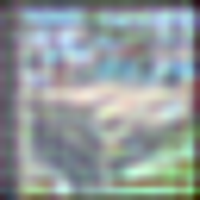

In [158]:
show_img(tmp_gen.initial_image)

In [159]:
torch.nn.Softmax(dim=1)(model(tmp_gen.initial_image))

tensor([[0.0839, 0.0474, 0.2993, 0.0800, 0.1148, 0.0203, 0.0037, 0.0168, 0.3248,
         0.0089]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [160]:
tmp_gen.reset_collection_state()